In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
#import linearmodels as lms # Panel models
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read and clean data

This data is all hands played on each hour on the site restricted to subsets where either a player played both before and during shock or during and after.

In [2]:
# Full Sample (old)
#sessions_full = pd.read_csv('c:/users/matt/desktop/poker paper/sessions full sample.csv')
# Sample on ephemeral players only
#sessions = pd.read_csv('c:/users/matt/desktop/poker paper/suckers.csv')
# Regular players
#sessions = pd.read_csv('c:/users/matt/desktop/poker paper/sessions_prepared.csv')

sessions = pd.read_csv('c:/users/matt/desktop/poker paper/sessions ev prep.csv')

sessions = sessions.drop('Unnamed: 0', 1).drop(sessions.loc[:, 'Time^2':], 1)
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])

sessions['wage'] = (sessions['My C Won']/sessions['Minutes'])*60
sessions['BB call EV'] = (sessions['BB vs SB call won (bb)']/sessions['BB vs SB call cnt'])
sessions['BB 3b EV'] = (sessions['won when 3bet pre']/sessions['BB vs SB 3b cnt'])

In [3]:
# set subsample!
#
#
sessions = sessions[sessions['ephemeral'] != 1]
#
#
#panel = sessions.set_index(['Session Start', 'Player'])

#daily_sessions = sessions.groupby(sessions.set_index('Session Start').index.date).mean()
#plt.plot(daily_sessions['My C Won'])

In [4]:
hourly = sessions.copy(deep=True)
hourly = hourly.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:, 'Time':'Time'], 1)

daily = sessions.copy(deep=True)
daily = daily.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:,'Midnight':'Time'], 1) 

hourly = hourly.set_index('Session Start')
daily = daily.set_index('Session Start')
daily_avg = daily.groupby(pd.TimeGrouper('1440Min')).mean()
hourly_avg = hourly.groupby(pd.TimeGrouper('60Min')).mean()
daily = daily.groupby(pd.TimeGrouper('1440Min')).sum()
hourly = hourly.groupby(pd.TimeGrouper('60Min')).sum()
hourly.loc[:, 'Treat':] = hourly_avg.loc[:, 'Treat':]
daily.loc[:, 'Treat':] = daily_avg.loc[:, 'Treat':]
hourly['wage'] = hourly_avg['wage']
daily['wage'] = daily_avg['wage']
hourly['Minutes avg'] = hourly_avg['Minutes']
daily['Minutes avg'] = daily_avg['Minutes']
hourly['Hands avg'] = hourly_avg['Hands']
daily['Hands avg'] = daily_avg['Hands']
hourly['My C Won avg'] = hourly_avg['My C Won']
daily['My C Won avg'] = daily_avg['My C Won']

hourly = hourly.fillna(0)
daily = daily.fillna(0)

In [5]:
# Clean Sessions dataset
sessions = sessions.sort_values(by='Session Start')
sessions = sessions.reset_index()
sessions = sessions.drop('index', 1)

In [6]:
# New dataset from grouped sessions average daily
daily_sessions = sessions.copy()
daily_sessions2 = sessions.copy()
daily_sessions = daily_sessions.groupby(daily_sessions.set_index('Session Start').index.date).mean()
daily_sessions2 = daily_sessions2.groupby(daily_sessions2.set_index('Session Start').index.date).median()
daily_sessions = daily_sessions.loc[:, :'Sunday']
daily_sessions['Minutes_median'] = daily_sessions2['Minutes']

# OLS on hands and rake aggregates

- Model on constant + dummies to test for intercept change

In [10]:
ols_est = sm.OLS(
        hourly['BB call EV'], 
        sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
    )).fit(cov_type='HC1')
#ols_est.summary()

In [8]:
# Output regressions
"""
for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
    ols_est = sm.OLS(
        hourly[endog_name], 
        sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
    )).fit(cov_type='HC1')
    
    ols_summary = ols_est.summary()
    text_file = open(str("c:/users/matt/desktop/hourly " + endog_name + " k means.txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

'\nfor endog_name in [\'My C Won\', \'Hands\', \'Hands avg\', \'Minutes\', \'Minutes avg\', \'Sessions\', \'My C Won avg\', \'wage\']:\n    ols_est = sm.OLS(\n        hourly[endog_name], \n        sm.add_constant(hourly.loc[:, \'Treat\':\'11PM\']#.drop(\'After\', 1)\n    )).fit(cov_type=\'HC1\')\n    \n    ols_summary = ols_est.summary()\n    text_file = open(str("c:/users/matt/desktop/hourly " + endog_name + " k means.txt"), "w")\n    text_file.write(ols_summary.as_text())\n    text_file.close()\n'

In [13]:
#
# OLS with "Learning"
#
X3 = hourly.loc[:, 'After':'11PM']
X3 = X3.reset_index().drop('Session Start', 1)
# First cutoff @ 1453
X3['Week 1'] = ((X3.index >= 1453) & (X3.index < 1620)).astype(int)
X3['Week 2'] = ((X3.index >= 1620) & (X3.index < 1787)).astype(int)
X3['Week 3'] = ((X3.index >= 1787) & (X3.index < 1954)).astype(int)
X3['Week 4'] = ((X3.index >= 1954) & (X3.index < 2121)).astype(int)
X3['Week 5'] = ((X3.index >= 2121) & (X3.index < 2288)).astype(int)
X3['Week 6'] = ((X3.index >= 2288) & (X3.index < 2455)).astype(int)
X3['Week 7'] = ((X3.index >= 2455) & (X3.index < 2622)).astype(int)
X3['Week 8'] = ((X3.index >= 2622) & (X3.index < 2789)).astype(int)
X3['Week 9'] = ((X3.index >= 2789) & (X3.index < 2959)).astype(int)
# Second cutoff @ 2959

X3 = sm.add_constant(X3)

In [16]:
y_learn = hourly['BB call EV'].reset_index()['BB call EV']
ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
#ols_learn.summary()

In [12]:
# Output regressions
"""
for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
    y_learn = hourly[endog_name].reset_index()[endog_name]
    ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
    
    ols_summary = ols_learn.summary()
    text_file = open(str("c:/users/matt/desktop/Hourly " + endog_name + " k means new -- Learn.txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

'\nfor endog_name in [\'My C Won\', \'Hands\', \'Hands avg\', \'Minutes\', \'Minutes avg\', \'Sessions\', \'My C Won avg\', \'wage\']:\n    y_learn = hourly[endog_name].reset_index()[endog_name]\n    ols_learn = sm.OLS(y_learn, X3).fit(cov_type=\'HC1\')\n    \n    ols_summary = ols_learn.summary()\n    text_file = open(str("c:/users/matt/desktop/Hourly " + endog_name + " k means new -- Learn.txt"), "w")\n    text_file.write(ols_summary.as_text())\n    text_file.close()\n'

# OLS on sessions panel (Fixed Effects)

In [37]:
"""
FE_panel = sm.add_constant(
          sessions.loc[:, 'Treat':].drop('wage', 1).drop('Time', 1)\
                  .join(pd.get_dummies(sessions['Player']))
            ).astype(float)
"""

FE_panel = pd.DataFrame(sessions['Player']).join(sessions.loc[:, 'Treat':'11PM'])

for col in FE_panel.columns[1:]:
    FE_panel[col] -= FE_panel.groupby('Player')\
                             [col].transform('mean')

        
FE_panel = sm.add_constant(FE_panel.drop('Player', 1))
        
"""    
for endog_name in [#'Hands', 'My C Won', 'Minutes',
                   #'Sessions', 'wage', 'Fold BB v SB', 
                   #'VPIP', 'CBet F', 'Total AF', '3Bet PF',
                   'BB call EV']:
    sessions_ols = sm.OLS(
        sessions[endog_name].fillna(0), 
        FE_panel
        ).fit(cov_type='HC1')   #NB: drop time if you want to

    ols_summary = sessions_ols.summary()
    text_file = open(str("c:/users/matt/desktop/PANEL " + endog_name + ".txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

** Plots & Summary **

In [18]:
ddhands = hourly.reset_index()
ddhands['index'] = ddhands.index

fitted_hands = ols_est.fittedvalues.copy()
fitted_hands = fitted_hands.reset_index()
fitted_hands.columns = ['index', 'fit']

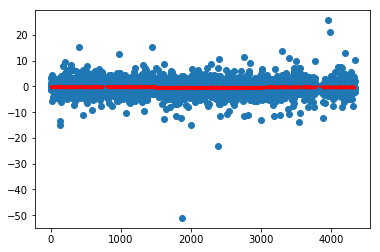

In [19]:
plt.scatter(ddhands.index, ddhands['BB call EV'])
plt.plot(fitted_hands['fit'], 'r')

# RDD

In [13]:
"""
# Detrended versions of Hands series
rddata_detrended_hands = sm.OLS(hourly['Hands'], sm.add_constant(hourly.loc[:, 'Tuesday':'11PM'])).fit().resid
rddata_detrended_hands = pd.DataFrame(rddata_detrended_hands)
rddata_detrended_hands['Treat'] = hourly['Treat']
rddata_detrended_hands.columns = ['Hands', 'Treat']
# Detrended daily
rddaily_detrended_hands = sm.OLS(daily['Hands'][:177], sm.add_constant(daily.loc[:, 'Tuesday':'Sunday'])[:177]).fit().resid
rddaily_detrended_hands = pd.DataFrame(rddaily_detrended_hands)
rddaily_detrended_hands['Treat'] = daily['Treat']
rddaily_detrended_hands.columns = ['Hands', 'Treat']
# Detrended versions of Minutes time series
rdsession_detrended_minutes = sm.OLS(daily_sessions['Minutes'], sm.add_constant(daily_sessions.loc[:, 'Tuesday':'Sunday'])).fit().resid
rdsession_detrended_minutes = pd.DataFrame(rdsession_detrended_minutes)
rdsession_detrended_minutes['Treat'] = daily_sessions['Treat']
rdsession_detrended_minutes.columns = ['Minutes', 'Treat']
"""

sessions_ols.resid()

In [14]:
hourly_data = hourly.reset_index().drop('Session Start', 1)
daily_data = daily.reset_index().drop('Session Start', 1)

rddata = hourly_data.loc[1000:2000] #Cutoff is at 1453rd observation
rddata_detrended_hands = rddata_detrended_hands[1000:2000]
rddaily = daily_data.loc[20:105] #Cutoff is at 62nd obs
rddaily_detrended_hands = rddaily_detrended_hands[20:105]
rdsession = daily_sessions.iloc[20:105] #Cutoff same as above
rdsession_detrended_minutes = rdsession_detrended_minutes[20:105]


# Reset the index to create the forcing RDD variable
def reset_data_index(data_in):
    data_in = data_in.reset_index()
    data_in['index'] = data_in.index
    data_in['forcing'] = data_in.index
    return data_in


# Make index X-cutoff by finding location of cutoff
def get_cutoff_index(indata):
    for i in range(len(indata)):
        if indata['Treat'][i] == 0:
            continue
        return i

#
# HOUR data cleaning
#
rddata = reset_data_index(rddata)
cutoff_loc = get_cutoff_index(rddata)
rddata['index'] -= cutoff_loc

# Detrended
rddata_detrended_hands = reset_data_index(rddata_detrended_hands)
cutoff_loc = get_cutoff_index(rddata_detrended_hands)
rddata_detrended_hands['index'] -= cutoff_loc

#
# DAILY data cleaning
#
rddaily = reset_data_index(rddaily)
cutoff_loc =  get_cutoff_index(rddaily)
rddaily['index'] -= cutoff_loc
# Detrended
rddaily_detrended_hands = reset_data_index(rddaily_detrended_hands)
cutoff_loc = get_cutoff_index(rddaily_detrended_hands)
rddaily_detrended_hands['index'] -= cutoff_loc

#
# SESSIONS data cleaning
#
rdsession = reset_data_index(rdsession)
cutoff_loc =  get_cutoff_index(rdsession)
rdsession['index'] -= cutoff_loc
# Detrended
rdsession_detrended_minutes = reset_data_index(rdsession_detrended_minutes)
cutoff_loc =  get_cutoff_index(rdsession_detrended_minutes)
rdsession_detrended_minutes['index'] -= cutoff_loc

In [15]:
def create_rd_indeces(indata):
    indata['index2'] = indata['index']**2
    indata['index3'] = indata['index']**3
    indata['treatIndex'] = indata['index'] * indata['Treat']
    indata['treatIndex2'] = rddata['index2'] * indata['Treat']
    indata['treatIndex3'] = indata['index3'] * indata['Treat']
    return indata

rddata = create_rd_indeces(rddata)
rddata_detrended_hands = create_rd_indeces(rddata_detrended_hands)
rddaily = create_rd_indeces(rddaily)
rddaily_detrended_hands = create_rd_indeces(rddaily_detrended_hands)
rdsession = create_rd_indeces(rdsession)
rdsession_detrended_minutes = create_rd_indeces(rdsession_detrended_minutes)

In [16]:
rddata['Handsavg'] = rddata['Hands avg']
rddaily['Handsavg'] = rddaily['Hands avg']
rddata['Minutesavg'] = rddata['Minutes avg']
rddaily['Minutesavg'] = rddaily['Minutes avg']

**Hands RDD**

In [28]:
# deg 1
rd_hands_inter = smf.ols("wage ~ Treat + index + treatIndex ", rddata).fit(cov_type='HC1')
rd_hands_inter_detrended = smf.ols("Hands ~ Treat + index + treatIndex ", rddata_detrended_hands).fit(cov_type='HC1')
rd_hands_inter_daily = smf.ols("wage ~ Treat + index + treatIndex", rddaily).fit(cov_type='HC1')
rd_hands_inter_daily_detrended = smf.ols("Hands ~ Treat + index + treatIndex", rddaily_detrended_hands).fit(cov_type='HC1')
# deg 2
rd_hands2_inter = smf.ols("wage ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit(cov_type='HC1')
rd_hands2_inter_detrended = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddata_detrended_hands).fit(cov_type='HC1')
rd_hands2_inter_daily = smf.ols("wage ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily).fit(cov_type='HC1')
rd_hands2_inter_daily_detrended = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily_detrended_hands).fit(cov_type='HC1')
#deg 3
rd_hands3_inter = smf.ols("wage ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata).fit(cov_type='HC1')
rd_hands3_inter_detrended = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata_detrended_hands).fit(cov_type='HC1')
rd_hands3_inter_daily = smf.ols("wage ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rddaily).fit(cov_type='HC1')
rd_hands3_inter_daily_detrended = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rddaily_detrended_hands).fit(cov_type='HC1')

rd_hands3_inter_daily.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     7.101
Date:                Mon, 24 Jul 2017   Prob (F-statistic):           1.48e-06
Time:                        17:59:08   Log-Likelihood:                -472.59
No. Observations:                  86   AIC:                             961.2
Df Residuals:                      78   BIC:                             980.8
Df Model:                           7                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.7223     38.298     -0.463      0.644     -92.784      57.340
Treat        2.655e+04   1.08e+05      0.247      0.805   -1.85e+05    2.38e+05
index          -7.8881      6.888     -1.145      0.252     -21.388       5.612
index2         -0.2728      0.379     -0.719      0.472      -1.016       0.470
index3         -0.0039      0.006     -0.658      0.511      -0.015       0.008
treatIndex    -98.3098    461.583     -0.213      0.831   -1002.996     806.377
treatIndex2    -0.1208      0.490     -0.247      0.805      -1.081       0.839
treatIndex3     0.0097      0.008      1.256      0.209      -0.005       0.025
==============================================================================
Omnibus:                        0.770   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.339
Skew:                           0.106   Prob(JB):                        0.844
Kurtosis:                       3.223   Cond. No.                     2.76e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.76e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
"""
model_counter = 0

for endog_name in [rd_hands_inter, rd_hands_inter_detrended, rd_hands_inter_daily,\
                   rd_hands_inter_daily_detrended, rd_hands2_inter, rd_hands2_inter_detrended,\
                   rd_hands2_inter_daily, rd_hands2_inter_daily_detrended, rd_hands3_inter,\
                   rd_hands3_inter_detrended, rd_hands3_inter_daily, rd_hands3_inter_daily_detrended]:
    model_counter += 1    
    ols_summary = endog_name.summary()
    text_file = open(str("c:/users/matt/desktop/RDD Hands " + str(model_counter) + ".txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()
"""

**Avg Minutes RDD**

Change "Minutes ~ ..." to "Minutes median ~ ..." For median minutes

In [20]:
# deg 1
rd_min_inter_daily = smf.ols("Minutes ~ Treat + index + treatIndex ", rdsession).fit(cov_type='HC1')
rd_min_inter_daily_detrended = smf.ols("Minutes ~ Treat + index + \
                                        treatIndex ", rdsession_detrended_minutes).fit(cov_type='HC1')
# deg 2
rd_min2_inter_daily = smf.ols("Minutes ~ treatIndex2 + Treat + treatIndex + index + index2", rdsession).fit(cov_type='HC1')
rd_min2_inter_daily_detrended = smf.ols("Minutes ~ Treat + index + index2 + \
                                        treatIndex + treatIndex2", rdsession_detrended_minutes).fit(cov_type='HC1')
# deg 3
rd_min3_inter_daily = smf.ols("Minutes ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rdsession).fit(cov_type='HC1')
rd_min3_inter_daily_detrended = smf.ols("Minutes ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rdsession_detrended_minutes).fit(cov_type='HC1')
#rd_min_inter_daily.summary()

** Plot **

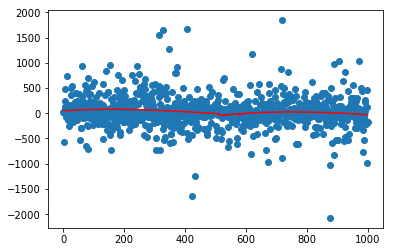

In [26]:
plt.scatter(rddata['forcing'], rddata['wage'])
plt.plot(rd_hands3_inter.fittedvalues, 'r')

# RD of 2nd cutoff

In [20]:
rddata2 = data.loc[2500:3500] #Cutoff is at 2959 observation
rddaily2 = daily.loc[85:155] #Cutoff is at 125nd obs

rddata2 = rddata2.reset_index()
rddata2['index'] = rddata2.index
rddata2['forcing'] = rddata2.index

rddata2['index'] -= get_cutoff_index(rddata2)

rddaily2 = rddaily2.reset_index()
rddaily2['index'] = rddaily2.index
rddaily2['forcing'] = rddaily2.index

rddaily2['index'] -= get_cutoff_index(rddaily2)

In [21]:
rddata2['index2'] = rddata2['index']**2
rddata2['index3'] = rddata2['index']**3
rddata2['treatIndex'] = rddata2['index'] * rddata2['Treat']
rddata2['treatIndex2'] = rddata2['index2'] * rddata2['Treat']
rddata2['treatIndex3'] = rddata2['index3'] * rddata2['Treat']

rddaily2['index2'] = rddaily2['index']**2
rddaily2['index3'] = rddaily2['index']**3
rddaily2['treatIndex'] = rddaily2['index'] * rddaily2['Treat']
rddaily2['treatIndex2'] = rddaily2['index2'] * rddaily2['Treat']
rddaily2['treatIndex3'] = rddaily2['index3'] * rddaily2['Treat']

**Rake RDD (2nd shock)**

In [22]:
after_rd_rake3_inter = smf.ols("Rake ~ After + index + index2 + index3 + \
                                treatIndex + treatIndex2 + treatIndex3", rddata2).fit(cov_type='HC1')
after_rd_rake3_inter_daily = smf.ols("Rake ~ After + + index + index2 + index3 +\
                                      treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')

after_rd_rake3_daily = smf.ols("Rake ~ Treat + index + index2 + index3", rddaily2).fit(cov_type='HC1')
#after_rd_rake3_inter.summary()
#after_rd_rake3_inter_daily.summary()
#after_rd_rake3_daily.summary()

In [23]:
after_rd_rake2_inter = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddata2).fit(cov_type='HC1')
after_rd_rake2_inter_daily = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
#after_rd_rake2_inter.summary()
#after_rd_rake2_inter_daily.summary()

**Hands RDD (2nd shock)**

In [24]:
after_rd_hands2_inter = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
after_rd_hands2_inter_daily = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
#after_rd_hands2_inter.summary()
#after_rd_hands2_inter_daily.summary()

In [25]:
after_rd_hands3_inter = smf.ols("Hands ~ After + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')
after_rd_hands3_inter_daily = smf.ols("Hands ~ After + + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')
#after_rd_hands3_inter.summary()
#after_rd_hands3_inter_daily.summary()

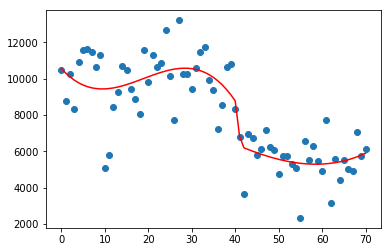

In [26]:
plt.scatter(rddaily2['index'], rddaily2['Rake'])
plt.plot(after_rd_rake3_inter_daily.fittedvalues, 'r')